# Modelo Binomial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tabulate import tabulate
from scipy.stats import norm
from math import comb
plt.style.use('ggplot')

### Parámetros:
- $n$: Número de periodos
- $u$: Factor crecimiento
- $d$: Factor disminución
- $r$: Tasa de rendimiento ($d<1+r<u$)
- $p$: Probabilidad crecimiento en 1 periodo
- $s$: Precio inicial acción
- $K$: Precio de ejercicio opción

In [2]:
n = 20
r = 0.01
u = 1.2
d = 0.8
p = (1+r-d)/(u-d)
s = 10
K = 12
N = 1000

### Precio C exacto
La función **g(n,s,u,d,r,K,y)** es:
$g(Y) = (su^Yd^{n-Y})^+$

La función **Eg(n,p,s,u,d,r,K,y)** es el cálculo de la esperanza de $g(Y)$, usando $Y \sim Bin(n,p)$ y la fórmula de esperanza de esta variable aleatoria.

In [3]:
def g(n,s,u,d,r,K,y):
    return max(s*u**y*d**(n-y)-K,0)

def Eg(n=n,p=p,s=s,u=u,d=d,r=r,K=K):
    cont = 0
    for i in range(0,n+1):
        sumando = g(n,s,u,d,r,K,i)*comb(n,i)*p**i*(1-p)**(n-i)
        cont += sumando
    return cont

In [4]:
C_binomial = Eg()*(1+r)**(-n)
C_binomial

3.552868187240386

### Precio C simulado

La función **intr_bin** devuelve el valor intrínseco de la opción de acuerdo al modelo binomial al final de $n$ periodos. Utiliza 1 variable aleatoria binomial.

La función **precios** devuelve el valor intrínseco de la opción de acuerdo al modelo binomial al final de $n$ periodos. Utiliza $n$ variables aleatorias Bernoulli. Además regresa una lista con el precio de la acción para cada periodo.

La función **C_sim** simula el valor presente esperado del valor intrínseco de la opción para $n$ periodos. 

In [51]:
def intr_bin(n=n,p=p,s=s,u=u,d=d,r=r,K=K):
    Y = np.random.binomial(size = 1, n = n, p = p).astype(float)[0]
    value = g(n,s,u,d,r,K,Y)
    return(value)

def precios(n=n,p=p,s=s,u=u,d=d,r=r,K=K):
    X_ber = np.random.binomial(size = n, n = 1, p = p).astype(float)
    Y = sum(X_ber)
    X = d+(u-d)*X_ber
    S = [s*np.prod(X[0:i]) for i in range(0,n+1)]
    value = g(n,s,u,d,r,K,Y)
    return(S, value)

def intr_ber(n=n,p=p,s=s,u=u,d=d,r=r,K=K):
    return precios(n=n,p=p,s=s,u=u,d=d,r=r,K=K)[1]

#N es el número de iteraciones para simular la esperanza
def C_sim(n,p,s,u,d,r,K,N,fun):
    cont = 0
    for i in range(0,N):
        cont += fun(n,p, s, u, d, r, K)
    C = (cont/N)*(1+r)**(-n)
    return(C)

In [46]:
#Ejemplos
C_sim(n,p,s,u,d,r,K,N, intr_bin)

3.736559494003893

In [47]:
C_sim(n,p,s,u,d,r,K,N, intr_ber)

3.529705720919755

### Trayectorias Precio Acción
A partir de la función **precios** se puede simular una trayectoria del precio de una acción en el modelo binomial,

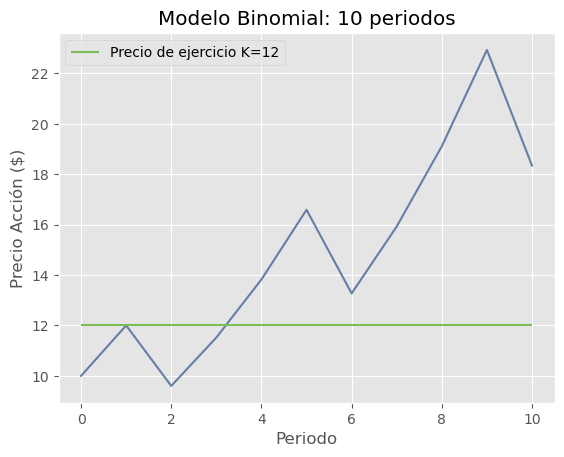

In [96]:
#Gráfica precios para n=10
plt.plot(precios(n=10)[0], color = "#657ea6")
plt.xlabel("Periodo")
plt.ylabel("Precio Acción ($)")
plt.hlines(K,0,10,color = "#7DBD55", label = "Precio de ejercicio K="+str(K))
plt.legend()
plt.title("Modelo Binomial: 10 periodos");

In [120]:
#Gráfica precios para n=100
plt.plot(precios(n=100)[0], color = "#657ea6")
plt.xlabel("Periodo")
plt.ylabel("Precio Acción ($)")
plt.hlines(K,0,100,color = "black, label = "Precio de ejercicio K="+str(K))
plt.legend()
plt.title("Modelo Binomial: 100 periodos");

SyntaxError: invalid syntax (4140781931.py, line 5)

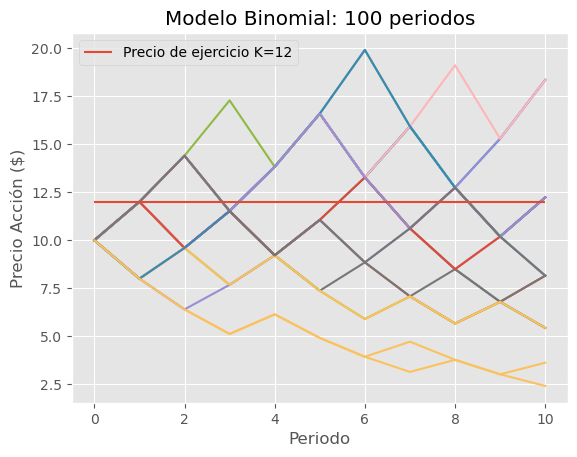

In [113]:
#Gráficas precios para n=10, 20 trayectorias
for i in range(1,20):
    plt.plot(precios(n=10)[0])
plt.xlabel("Periodo")
plt.ylabel("Precio Acción ($)")
plt.hlines(K,0,10, label = "Precio de ejercicio K="+str(K))
plt.legend()
plt.title("Modelo Binomial: 100 periodos");
plt.show()

### Comparación Simulaciones
Se mide el tiempo que le toma a cada método, variano $N$ el número de iteraciones para 1 simulación de $C$\
También se varía el número de simulaciones de $C$ y se mide el tiempo de acuerdo a este parámetro.\
Se calcula en cada caso el error relativo, usando la función **Eg**.\
Los resultados se muestran en una tabla y también gráficamente.
Se muestra un histograma con los precios C calculados con cada método, y como referencia el precio exacto de la opción.

In [59]:
def tiempo(it,N,func,n=n,p=p,s=s,u=u,d=d,r=r,K=K):
    start = timer()
    l = [C_sim(n,p,s,u,d,r,K,N,func) for _ in range(it)]
    C = sum(l)/it
    end = timer()
    error = abs(C- Eg()*(1+r)**(-n))/(Eg()*(1+r)**(-n))
    return(end-start, error)


In [67]:
tabla = [["# Precios C","N","Tiempo Bin","Error relativo","Tiempo Ber","Error relativo"],
         [1,1000,tiempo(it=1,N=1000,func = intr_bin)[0],tiempo(it=1,N=1000,func = intr_bin)[1],
                 tiempo(it=1,N=1000,func = intr_ber)[0],tiempo(it=1,N=1000,func = intr_ber)[1]],
         
         [1,10000,tiempo(it=1,N=10000,func = intr_bin)[0],tiempo(it=1,N=10000,func = intr_bin)[1],
                  tiempo(it=1,N=10000,func = intr_ber)[0],tiempo(it=1,N=10000,func = intr_ber)[1]], 
         
         [20,1000,tiempo(it=20,N=1000,func = intr_bin)[0],tiempo(it=20,N=1000,func = intr_bin)[1],
                  tiempo(it=20,N=1000,func = intr_ber)[0],tiempo(it=20,N=1000,func = intr_ber)[1]], 

         [20,10000,tiempo(it=20,N=10000,func = intr_bin)[0],tiempo(it=20,N=10000,func = intr_bin)[1],
                   tiempo(it=20,N=10000,func = intr_ber)[0],tiempo(it=20,N=10000,func = intr_ber)[1]], 

         
         [100,1000,tiempo(it=100,N=1000,func = intr_bin)[0],tiempo(it=100,N=1000,func = intr_bin)[1],
                   tiempo(it=100,N=1000,func = intr_ber)[0],tiempo(it=100,N=1000,func = intr_ber)[1]], 

         [100,10000,tiempo(it=100,N=10000,func = intr_bin)[0],tiempo(it=100,N=10000,func = intr_bin)[1],
                    tiempo(it=100,N=10000,func = intr_ber)[0],tiempo(it=100,N=10000,func = intr_ber)[1]] ]

#obs: a esa tabla quiero agregarle el error relativo, para ver qué tanto vale la pena el tiempo que tardan
print(tabulate(tabla, headers = "firstrow", tablefmt = "fancy_grid"))

╒═══════════════╤═══════╤══════════════╤══════════════════╤══════════════╤══════════════════╕
│   # Precios C │     N │   Tiempo Bin │   Error relativo │   Tiempo Ber │   Error relativo │
╞═══════════════╪═══════╪══════════════╪══════════════════╪══════════════╪══════════════════╡
│             1 │  1000 │     0.02286  │      0.124749    │     0.264739 │       0.119851   │
├───────────────┼───────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│             1 │ 10000 │     0.171928 │      0.00393649  │     2.83349  │       0.0332473  │
├───────────────┼───────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│            20 │  1000 │     0.332902 │      0.000493517 │     4.86786  │       0.00463949 │
├───────────────┼───────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│            20 │ 10000 │     3.47317  │      0.00317255  │    54.6359   │       0.00606798 │
├───────────────┼───────┼──────────────┼──────────────────┼─

In [72]:
C = [1,10,20,30,40,50,60,70,80,90,100]
t_bin_1000 = [tiempo(it=i,N=1000,func = intr_bin)[0] for i in C]
t_ber_1000 = [tiempo(it=i,N=1000,func = intr_ber)[0] for i in C]

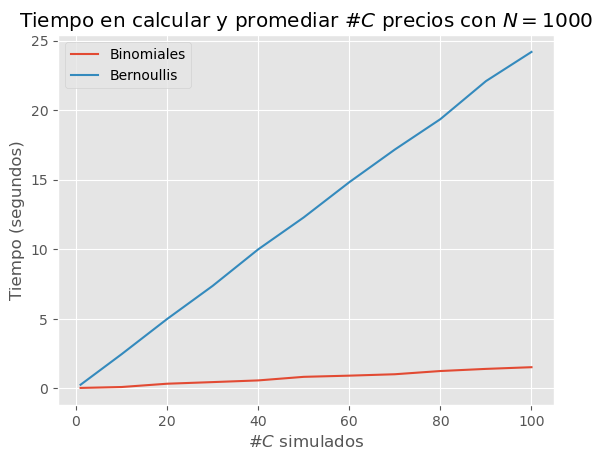

In [86]:
plt.plot(C,t_bin_1000, label = "Binomiales")
plt.plot(C,t_ber_1000, label = "Bernoullis")
plt.xlabel("#$C$ simulados")
plt.ylabel("Tiempo (segundos)")
plt.title("Tiempo en calcular y promediar #$C$ precios con $N=1000$")
plt.legend()
plt.show()

In [91]:
e_bin_1000 = [tiempo(it=i,N=1000,func = intr_bin)[1] for i in C]
e_ber_1000 = [tiempo(it=i,N=1000,func = intr_ber)[1] for i in C]

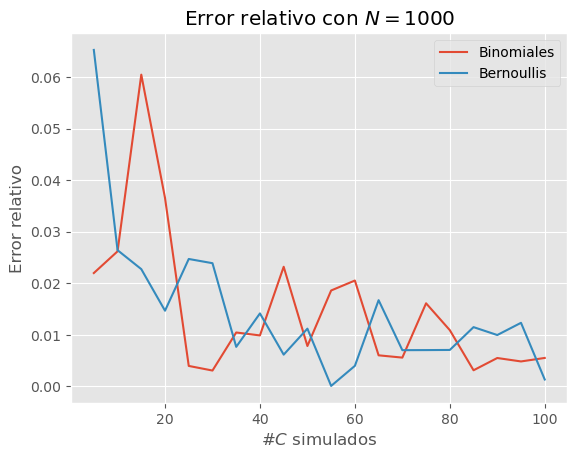

In [92]:
plt.plot(C,e_bin_1000, label = "Binomiales")
plt.plot(C,e_ber_1000, label = "Bernoullis")
plt.xlabel("#$C$ simulados")
plt.ylabel("Error relativo")
plt.title("Error relativo con $N=1000$")
plt.legend()
plt.show()

In [66]:
sim1 = [C_sim(n,p,s,u,d,r,K,N,intr_bin) for _ in range(2000)]
sim2 = [C_sim(n,p,s,u,d,r,K,N,intr_ber) for _ in range(2000)]

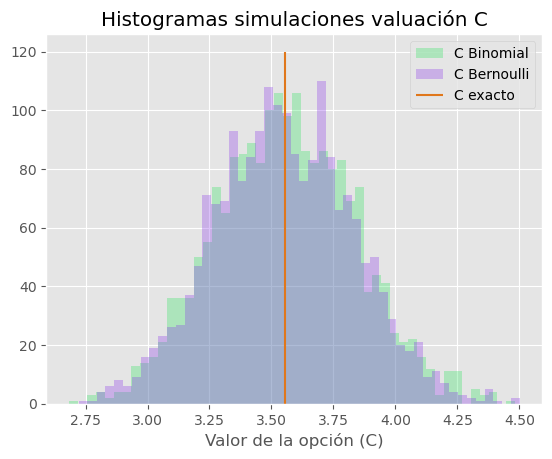

In [65]:
plt.xlabel("Valor de la opción (C)")
plt.title("Histogramas simulaciones valuación C")
plt.hist(sim1, bins = 50, color = "#2be35c", alpha = 0.3 , label = "C Binomial")
plt.hist(sim2, bins = 50, color = '#8934eb',alpha = 0.3, label = "C Bernoulli")
plt.vlines(Eg()*(1+r)**(-n),0,120, color = "#e0771b", label = "C exacto" )
plt.legend()
plt.show()